# 2 Лабораторная работа: GARCH(p, q)

## Описание функций

In [1]:
GenerateGRACH_1_0<-function(a0,a1,n){
    epsilon <- rnorm(1000)
    sigma <- numeric(1000)
    h <- numeric(1000)
    sigma[1] <- sqrt(a0 / (1 - a1))
    h[1] <- epsilon[1] * sigma[1]
    for (i in 2:1000) {
      sigma[i] <- sqrt(a0 + a1 * h[i - 1]^2)
      h[i] <- epsilon[i] * sigma[i]
    }
    return( list(sigma = sigma, h = h) )
}


## 1. График
Построить график стационарного процесса $\{h_n\}$ и график волатильности $ \{\sigma_n\}$ процесса $GARCH(1,0)$, из $n = 1000$ наблюдений.


In [2]:
garch <- GenerateGRACH_1_0(.1, .7, 1000)

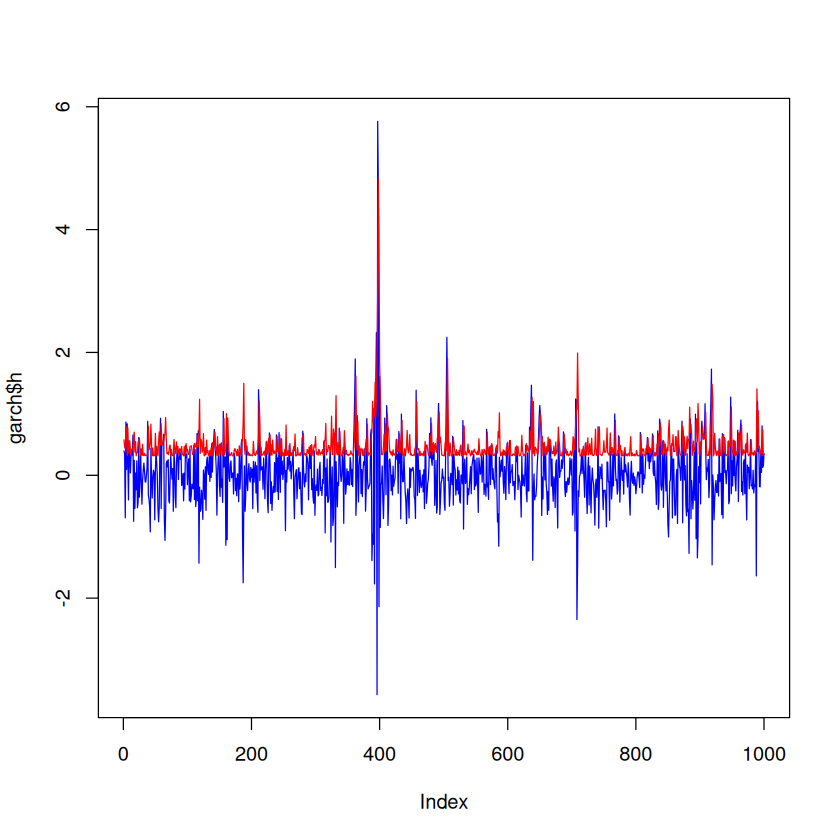

In [3]:
plot(garch$h, type = "l", col = "blue")
lines(garch$sigma, col = "red")